# PROJECT: Course Optimization for Data Science 2022-2023
## Optimization strategies for the "smoothed" quantile regression with (non-)smooth penalties

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradient of a smoothed pinball loss used for quantile regression
- Implement your own solvers for L1 and L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for L1 or L2 regularized smoothed-quantile regression model and test it on a real dataset where we will look at prediction invtervals.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 2nd of January 2023 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [14]:
# Change here using YOUR first and last names
fn1 = "pierre"
ln1 = "ablin"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_ablin_pierre_and_gramfort_alexandre.ipynb


Some imports

In [15]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 1: Smoothed quantile regression model

[Quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) is a supervised learning regression model with target space $\mathcal{Y} = \mathbb{R}$. It is a method widely used in statistics to obtain prediction intervals, and it is very often used in time series forecasting.

We consider observations $x \in \mathbb{R}^{P}$. $P$ is the number of features, and we will denote the $N$ observations available in the training set as $x_1, \dots, x_N$.

We consider a linear model, _i.e.,_ we want to learn the parameters $\theta = (w, b) \in \mathbb{R}^{P}\times \mathbb{R}$ such that the value of $w^\top x + b$ is the $\tau$-quantile of the conditional distribution $y | x$. For example, for $\tau=0.5$, we want to learn the parameters such that the value of $w^\top x + b$ is the *median* of the conditional distribution $y | x$. For $\tau=0.9$, we want to learn the parameters such that the value of $w^\top x + b$ is the *90th percentile* of the conditional distribution $y | x$, meaning that 90% of the observations of $y | x$ are below $w^\top x + b$.

An estimate $\hat{q}$ of the $\tau$-conditional sample quantile is obtained by minimizing the following loss function:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N
    \left[
            (\tau - 1) \mathbb{1}_{\{y_i < q\}} (y_i - q) + 
            \tau \mathbb{1}_{\{y_i \geq q\}} (y_i - q)
    \right]
$$

The function $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{\{z \leq 0\}} (z) + \tau \mathbb{1}_{\{z \geq 0\}} (z)$ is known as the **pinball loss**. The above loss can then be rewritten as:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - q) \enspace.
$$
The optimization problem becomes:
$$
\hat{w}, \hat{b} = \arg\min_{w, b} L(w, b)
    \enspace \mathrm{with} \enspace L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)
$$

Introducing some regularization on the parameter $w$ with parameter $\lambda \ge 0$, the penalized estimation problem is written:

$$
    (\mathcal{P}^{\mathcal{R}}):
	\min_{w \in \mathbb{R}^P, b \in \mathbb{R}} \quad L(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be :
- $\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^P |w_{j}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^P w_{j}^2$, ie. a squared $\ell_2$ norm

Here is an implementation of the pinball loss:

In [16]:
def pinball(z, tau=0.5):
    """Compute the pinball loss for z and a quantile tau.

    Parameters
    ----------
    z : ndarray, shape (n_samples,)
        The values on which to compute the pinball loss.
    tau : float in [0, 1]
        The quantile.
    
    Returns
    -------
    loss : ndarray, shape (n_samples,)
        The value of the pinball loss for each value of z.
    """
    sign = (z >= 0).astype(z.dtype)
    loss = tau * sign * z - (1 - tau) * (1 - sign) * z
    return loss

#### QUESTION 0

- Plot the pinball loss for tau=0.3, 0.5 and 0.7.

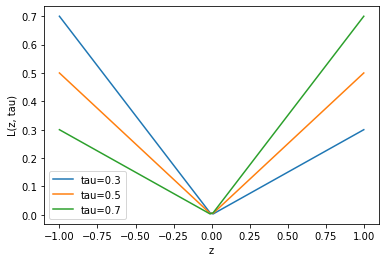

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
y = np.linspace(-1, 1, 100)
tau_values = [0.3, 0.5, 0.7]

# Plot pinball loss for different values of tau
plt.figure()
for tau in tau_values:
  plt.plot(y, pinball(y, tau), label=f'tau={tau}')

plt.xlabel('z')
plt.ylabel('L(z, tau)')
plt.legend()
plt.show()

#### QUESTION 1:

- Justify that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.
- Can you readily apply gradient descent or proximal gradient descent to solve these two problems? You will justify your answer by commenting on the smoothness of the objective functions.

- Justify that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.

To show that an optimization problem is convex, we need to show that the objective function is convex.

The objective function in both $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ is of the form $L(w, b) + \lambda \mathcal{R}(w)$, where $L(w, b)$ is the pinball loss function and $\mathcal{R}(w)$ is either the $\ell_1$ norm or the squared $\ell_2$ norm, which are both convex functions. Therefore, we need to prove that pinball loss function $L(w, b)$ is convex, because the sum of two convex functions is convex.

To show that the pinball loss function $L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)$ is convex, we need to show that the function $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{{z \leq 0}} (z) + \tau \mathbb{1}_{{z \geq 0}} (z)$ is convex.
We have $0<\tau<1$.

Recall that a function $f(x)$ is convex if and only if for any $x_1, x_2 \in \mathbb{R}$ and any $\alpha \in [0, 1]$, we have:

$$
f(\alpha  x_1 + (1 - \alpha) x_2) \le \alpha f(x_1) + (1 - \alpha) f(x_2)
$$

We can prove that the function $\ell_\tau(z)$ is convex by showing that it satisfies the convexity inequality. Let $z_1, z_2 \in \mathbb{R}$ and $\alpha \in [0, 1]$.We will divide the proof in 3 cases depending on the sign of $z_1$ and $z_2$.

Case 1: $z_1 < 0$ and $z_2 <0$

Thus $\alpha z_1 + (1 - \alpha) z_2 < 0$ which implies 
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) &= (\tau - 1) (\alpha z_1 + (1 - \alpha) z_2)
\end{aligned}
$$
On the other hand $z_1 < 0$ and $z_2 <0$ implies
$$
\begin{aligned}
\alpha \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2) &= \alpha (\tau - 1) z_1 + (1 - \alpha)(\tau - 1) z_2 = (\tau - 1) (\alpha z_1 + (1 - \alpha) z_2) 
\end{aligned}
$$
Then
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) \alpha &= \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2)  
\end{aligned}
$$

Case 2 : $z_1 > 0$ and $z_2 > 0$.

Thus $\alpha z_1 + (1 - \alpha) z_2 > 0$ which implies 
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) &= \tau  (\alpha z_1 + (1 - \alpha) z_2)
\end{aligned}
$$
On the other hand $z_1 > 0$ and $z_2 > 0$ implies
$$
\begin{aligned}
\alpha \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2) &= \alpha \tau  z_1 + (1 - \alpha)\tau z_2 = \tau (\alpha z_1 + (1 - \alpha) z_2) 
\end{aligned}
$$
Then
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) \alpha &= \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2)  
\end{aligned}
$$

Case 3 : $z_1 < 0$ and $z_2 > 0$.

Case 3a) : $\alpha$ is such that  $\alpha z_1 + (1 - \alpha) z_2 < 0$ which implies 
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) &= (\tau - 1)  (\alpha z_1 + (1 - \alpha) z_2)
\end{aligned}
$$
On the other hand $z_1 < 0$ and $z_2 > 0$  implies
$$
\begin{aligned}
\alpha \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2) &= \alpha (\tau - 1)  z_1 + (1 - \alpha)\tau z_2 
\end{aligned}
$$
$(\tau - 1) (1 - \alpha) z_2 < 0$ and $(1 - \alpha)\tau z_2  > 0$ because $0<\tau<1$ and $z_2>0$,then
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) &<= \alpha  \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2)  
\end{aligned}
$$

Case 3b) : $\alpha$ is such that  $\alpha z_1 + (1 - \alpha) z_2 > 0$ which implies 
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) &= \tau  (\alpha z_1 + (1 - \alpha) z_2)
\end{aligned}
$$
On the other hand $z_1 < 0$ and $z_2 > 0$ still implies
$$
\begin{aligned}
\alpha \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2) &= \alpha (\tau - 1)  z_1 + (1 - \alpha)\tau z_2 
\end{aligned}
$$
$\tau \alpha z_1 < 0$ and $\alpha (\tau - 1)  z_1 > 0$ because $0<\tau<1$ and $z_1<0$,then
$$
\begin{aligned}
\ell_\tau(\alpha z_1 + (1 - \alpha) z_2) &<= \alpha  \ell_\tau(z_1) + (1 - \alpha) \ell_\tau(z_2)  
\end{aligned}
$$

In all cases, the convex inequality is verifieds. Therefore, the function $\ell_\tau(z)$ satisfies the convexity inequality, and is therefore a convex function.
The function $f(w, b) = y_i - w^\top x_i - b$ is a linear function in the variables $w$ and $b$, and therefore it is a convex function.
Therefore the pinball loss function $L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)$ is also convex.

We can conclude that the objective function in both $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ is convex.

- Can you readily apply gradient descent or proximal gradient descent to solve these two problems? You will justify your answer by commenting on the smoothness of the objective functions.

Both gradient descent and proximal gradient descent can be used to solve the optimization problems $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$.

Gradient descent is a first-order optimization algorithm that iteratively updates the values of the parameters $w$ and $b$ by moving in the opposite direction of the gradient of the objective function. Proximal gradient descent is a variant of gradient descent that includes a proximal term, which helps to enforce certain constraints or regularization on the parameters.

To use gradient descent or proximal gradient descent to solve these optimization problems, we need to compute the gradients of the objective function with respect to the parameters $w$ and $b$. This requires that the objective function is differentiable, which means that the partial derivatives of the objective function with respect to the parameters exist and are continuous.

In the case of the pinball loss function $L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)$, the function $\ell_\tau(z)$ is not differentiable at $z = 0$, because the derivative is not defined at this point.

In summary, the objective functions in the optimization problems $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are the sum of the pinball loss function and a regularization term. They are not smooth, because the pinball loss function is not differentiable, but it can still be minimized using subgradient descent.

Let us illustrate what type of solution one obtains when minimizing the pinball loss. For now, we will use a black-box optimization method from `scipy`.

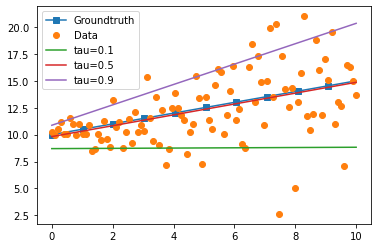

In [18]:
import numpy as np
from scipy.optimize import minimize

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]  # make X two-dimensional with one column
y_true = 10 + 0.5 * x
y = y_true + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
tau = 0.3

def pobj(wb, tau):
    w, b = wb[:1], wb[-1]
    return np.mean(pinball(y - X @ w - b, tau=tau))

for tau in [0.1, 0.5, 0.9]:
    w_hat, b_hat = minimize(lambda wb : pobj(wb, tau), x0=[0, 0]).x
    plt.plot(x, x * w_hat + b_hat, label=f"tau={tau}")

plt.legend()

One can observe that the predictions obtained with 0.1 and 0.9 form an interval that can be used to evaluate the uncertainty of the prediction.

## Smoothed pinball loss

Let us define the function:

$$
    \ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} \quad
    \underbrace{
        \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
    }_{J(u)}
$$

#### QUESTION 2:
- Justify that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of z.
- Prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.
- Prove that the function $\ell_\tau^\delta$ is given by the formula just below:

$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

- Justify that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of z.
To show that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, we need to prove that a unique function value exists for each value of $z$.

The function $\ell_\tau^\delta(z)$ is defined as the minimum value of the function $J(u)$ for a given value of $z$:

$$
    \ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} \quad
    \underbrace{
        \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
    }_{J(u)}
$$

To show that a unique function value exists for each value of $z$, we need to show that the function $J(u)$ has a unique minimum value for each value of $z$.

The squared error term is defined as:

$$
\frac{1}{2\delta} (z - u)^2
$$

We have $J(u) = \ell_\tau(u) + g_{z,\delta}(u)$

But $$\ell_\tau(u) \le |u|$$ 

So $\lim\limits_{|u| \to \infty}J(u) = \infty \text{ so } J \text{ is coercive}$


$J$ is coercive and continue so $J$ has a minimum on $\mathbb{R}$.

This means that the function $\ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of $z$.

- Prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.

Let's prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.

Let be $\delta > 0$, $z \in \mathbb{R}$

$\ell_\tau^{\delta}(z) =  \min_{u \in \mathbb{R}} \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2 $ 

So, $$\forall u \in \mathbb{R},  \ell_\tau^{\delta} (z)\le \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 $$

In particular, the inequality is true for $z$ which gives :

$$\ell_\tau^{\delta} (z)\le \ell_\tau(z)$$

- Prove that the function $\ell_\tau^\delta$ is given by the formula just below:

$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

To prove that the function $\ell_\tau^\delta$ is given by the formula provided, we need to show that the definition of $\ell_\tau^\delta$ satisfies the conditions in the formula.

Let's prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.

Let be $\delta > 0$, $z \in \mathbb{R}$

$\ell_\tau^{\delta}(z) =  \min_{u \in \mathbb{R}} \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2 $ 

So, $$\forall u \in \mathbb{R},  \ell_\tau^{\delta} (z)\le \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 $$

In particular, the inequality is true for $z$ which gives :

$$\ell_\tau^{\delta} (z)\le \ell_\tau(z)$$

If $0 \le z < \delta \tau$, $$\forall u \in \mathbb{R}_{-}\ell_\tau(u)  + \frac{1}{2\delta} (z - u)^2  \ge \frac{1}{2\delta} z^{2} $$

And $$\forall u \in \mathbb{R}_{+} \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 = \tau u +  \tfrac{1}{2\delta} (z - u)^2 $$

$$\implies \forall u \in \mathbb{R}_{+} \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 = \frac{1}{2\delta}\big[(u - (\delta\tau - z))^2 + 2z\delta\tau - \delta^2\tau^2\big] $$

So the minimum would be attained in $$u = z - \delta\tau < 0$$ but we have $u \ge 0$ so the minimum is attained in $u = 0$ and we have 

$$ \ell_\tau(0) + \tfrac{1}{2\delta} (z - 0)^2 = \frac{z^2}{2\delta}$$

So, $$\implies \forall u \in \mathbb{R}, \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 \le \frac{z^2}{2\delta} \text{ with equality in } u = 0$$

So, $$\ell_\tau^\delta (z) = \frac{z^2}{2 \delta} \text{ if } 0 \le z < \delta \tau  $$



If $ - \delta (1 - \tau) \le z < 0$, $$\forall u \in \mathbb{R}_{+}\ell_\tau(u)  + \frac{1}{2\delta} (z - u)^2  \ge \frac{1}{2\delta} z^{2} $$

And $$\forall u \in \mathbb{R}_{-} \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 = - (1 -\tau )u +  \tfrac{1}{2\delta} (z - u)^2 $$

$$\implies \forall u \in \mathbb{R}_{-} \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 = \frac{1}{2\delta}\big[(u - (\delta(1 - \tau) + z))^2 - 2z\delta(1-\tau) - \delta^2(1-\tau)^2\big] $$
So the minimum would be attained in $u = \delta(1 - \tau) + z > 0$ but we have $u \le 0$ so the minimum is attained in $u = 0$ and we have 

$$ \ell_\tau(0) + \tfrac{1}{2\delta} (z - 0)^2 = \frac{z^2}{2\delta}$$

So, $$\implies \forall u \in \mathbb{R}, \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 \le \frac{z^2}{2\delta} \text{ with equality in } u = 0$$

So, $$\ell_\tau^\delta (z) = \frac{z^2}{2 \delta} \text{ if } - \delta (1 - \tau) \le z < 0 $$





If $z < - \delta (1-\tau)$,



And, $$\frac{1}{2\delta}z^{2} -  (1- \tau) \big(- z - \frac{\delta}{2}(1 - \tau)\big) \ge 0$$

We can prove it by derivating the function on $[- \infty, - \delta(1 - \tau)]$, the derivative is negative so the function is decreasing on the interval and is equal to 0 in $z = -\delta(1 - \tau)$


Thus,
 
$$\forall u \in \mathbb{R}_{+}, \ell_\tau(u) +  \frac{1}{2\delta} (z - u)^{2} \ge   \frac{1}{2\delta} z^{2} \ge (1- \tau) \big(- z - \frac{\delta}{2}(1 - \tau)\big)  $$

And $$\forall u \in \mathbb{R}_{-} \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 = -(1 -\tau )u +  \tfrac{1}{2\delta} (z - u)^2 $$

$$\implies \forall u \in \mathbb{R}_{-} \ell_\tau(u)  + \tfrac{1}{2\delta} (z - u)^2 = \frac{1}{2\delta}\big[(u - (\delta(1 - \tau) + z))^2 - 2z\delta(1-\tau) - \delta^2(1-\tau)^2\big] $$
So the minimum would be attained in $u^{*} = \delta(1 - \tau) + z < 0$ and we have :

$$\ell_\tau(u^{*})  + \tfrac{1}{2\delta} (z - u^{*})^2 = (1 - \tau)\big(- z - \frac{\delta}{2}(1 - \tau)\big)$$

So, $$\ell_\tau^{\delta}(z) =  (1 - \tau)\big(- z - \frac{\delta}{2}(1 - \tau)\big) \text{ if } z < - \delta(1 - \tau)$$

#### QUESTION 3:
- Implement the function `smooth_pinball(z, tau, delta)` that applies $\ell_\tau^\delta$ to each entry a numpy array. You will plot the function `smooth_pinball` and `pinball` between -2 and 2.

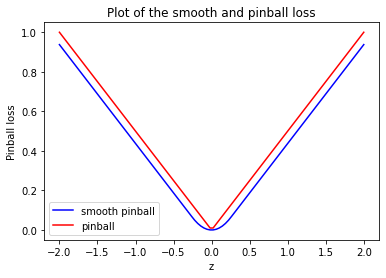

In [19]:
def smooth_pinball(z, tau, delta):
    """Compute the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    l : array-like, shape (n_samples,)
        The smoothed pinball loss values.
    """
    losses = np.zeros_like(z)
    losses[z >= delta * tau] = tau * (z[z >= delta * tau] - delta * tau / 2)
    losses[(0 <= z) & (z < delta * tau)] = z[(0 <= z) & (z < delta * tau)] ** 2 / (2 * delta)
    losses[(-delta * (1 - tau) <= z) & (z < 0)] = z[(-delta * (1 - tau) <= z) & (z < 0)] ** 2 / (2 * delta)
    losses[z < -delta * (1 - tau)] = (1 - tau) * (-z[z < -delta * (1 - tau)] - delta * (1 - tau) / 2)
    return losses

### TODO plotting

x = np.linspace(-2, 2, 100)
plt.plot(x,smooth_pinball(x, 0.5,0.5), c='b', label = 'smooth pinball')
plt.plot(x,pinball(x, 0.5), c='r', label = 'pinball')
plt.ylabel('Pinball loss')
plt.xlabel("z")
plt.legend()
plt.title("Plot of the smooth and pinball loss")
plt.show()

### END TODO

#### QUESTION 4:
- What is the derivative of the smoothed pinball loss $\ell_\tau^\delta$?
- Justify that the derivative of the smoothed pinball loss is continuous.
- Justify that the function $\ell_\tau^\delta$ is L-smooth. Propose a value for the Lipschitz constant of its gradient.
- Justify that the function $\ell_\tau^\delta$ is convex. Is it strongly convex?
- Implement the function `grad_smooth_pinball(z, tau, delta)` that applies the derivative of $\ell_\tau^\delta$ to each entry of a numpy array.

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the function (not just in one location).

- The derivative of the smoothed pinball loss is:
$$
    \partial \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z}{\delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z}{\delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    \tau-1 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

- Justify that the derivative of the smoothed pinball loss is continuous: 

Firstly, the derivative of the smoothed pinball loss is defined at every point in its domain, which is the set of all real numbers.

$$
     \partial \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	& \quad \mathrm{ if } \quad z = 0  : \frac{\tau * 0}{\delta} = 0  ~~~~~and~~~~~  \frac{(1-\tau) * 0}{\delta} = 0\\
	& \quad \mathrm{ if } \quad  z = \delta : \frac{\tau * {\delta}}{\delta} = {\delta} ~~~~~and~~~~~ \tau = \tau   \\
	& \quad \mathrm{ if } \quad  z = -\delta (1 - \tau) : \frac{-\delta (1 - \tau)}{\delta} = \tau-1 ~~~~~and~~~~~ \tau-1 = \tau-1\\
	\end{aligned}
    \right.
$$

We can see that $\partial \ell_\tau^\delta (z)$ is continuous in 0, $\delta$ and $-\delta (1 - \tau)$

- Justify that the function $\ell_\tau^\delta$ is L-smooth. Propose a value for the Lipschitz constant of its gradient.

The derivative is continuous and can be derived, the second derivative is given by the following formula : 
$$
    \partial \ell_\tau^{2,\delta}(z) = \left\{
	\begin{aligned}
	0 & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{1}{\delta} & \quad \mathrm{ if } \quad -\delta (1 - \tau)  \le z < \tau \delta \\
    0 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

The L-smooth constant we can take is $\frac{1}{\delta}$ since it's a majoring constant of the second derivative

- Justify that the function $\ell_\tau^\delta$ is convex. Is it strongly convex?

The function is convex since the second derivative is positive.

To check if the function is strongly convex, we need to check if its second derivative is positive. The second derivative of $\ell_\tau^\delta$ has three different expressions depending on the value of $z$.

If $0 \leq z < \tau \delta$ or $-\delta (1 - \tau) \leq z < 0$, the second derivative is given by $\frac{1}{\delta}$. This second derivative is positive for all values of $\delta > 0$.

If $\delta \tau \leq z$ or $z < -\delta (1 - \tau)$ or $z \geq \tau \delta$, the second derivative is given by 0.

Therefore, the function $\ell_\tau^\delta$ is strongly convex when $0 \leq z < \tau \delta$ or $-\delta (1 - \tau) \leq z < 0$. In the other cases, the function is only convex. So the function isn't strongly convex.

2.9802322831784522e-09

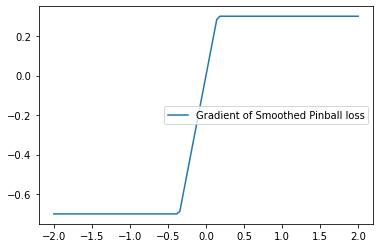

In [20]:
def grad_smooth_pinball(z, tau, delta):
    """Compute the derivative of the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    dl : array-like, shape (n_samples,)
        The derivative of smoothed pinball loss computed element-wise.
    """
    out = np.empty_like(z)
    out[z >= delta * tau] = tau
    out[(0 <= z) & (z < delta * tau)] = z[(0 <= z) & (z < delta * tau)] / delta
    out[(-delta * (1 - tau) <= z) & (z < 0)] = z[(-delta * (1 - tau) <= z) & (z < 0)] / delta
    out[z < -delta * (1 - tau)] = tau - 1
    return out

x = np.linspace(-2, 2, 100)
tau = 0.3
plt.plot(x, grad_smooth_pinball(x, tau=tau, delta=.5), label='Gradient of Smoothed Pinball loss')
plt.legend();

from scipy.optimize import check_grad

### TODO check gradient with check_grad function.
check_grad(smooth_pinball,grad_smooth_pinball,np.array(np.random.randn()),tau,0.5)
### END TODO

From now on, we consider the following optimization problem:

$$
    (\mathcal{P}_\delta^\mathcal{R}): \min_{w, b} \quad L_\delta(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be $\mathcal{R}_1(w)$ or $\mathcal{R}_2(w)$, and where $L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$.

#### QUESTION 5:
- Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable
  for $(\mathcal{P}_\delta^{\mathcal{R}_2})$ and $(\mathcal{P}_\delta^{\mathcal{R}_1})$.

### Answer here
L-BFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimization algorithm that uses an approximation of the Hessian matrix to compute the search direction at each iteration. It is well-suited for optimization problems with a large number of variables and is often used for training machine learning models.

Proximal gradient descent is an optimization algorithm that combines gradient descent with the proximal operator, which can be used to incorporate regularization terms into the optimization problem. Proximal gradient descent is well-suited for optimization problems with smooth objective functions and simple constraints.

Proximal coordinate descent is an optimization algorithm that alternates between optimizing each coordinate of the variables independently, using proximal gradient descent or another optimization algorithm. It is well-suited for optimization problems with a large number of variables and is often used for training machine learning models with structured sparsity constraints, such as those found in Lasso regression.

For the optimization problem $(\mathcal{P}_\delta^{\mathcal{R}2})$, L-BFGS or proximal gradient descent would be readily applicable. For the optimization problem $(\mathcal{P}\delta^{\mathcal{R}_1})$, proximal gradient descent or proximal coordinate descent would be readily applicable.

#### QUESTION 6:
- Solve the optimization prolem $(\mathcal{P}_\delta^{\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
- Using the simulated dataset from above, you will check that your solver gives comparable results as obtained above without smoothing when setting a very small value for $\lambda$. Your are expected to make a plot of the regression fit.

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you, we provide you with the function `pobj_l2` that computes the objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

To solve the optimization problem $(\mathcal{P}_\delta^{\mathcal{R}_2})$ using the fmin_l_bfgs_b function from scipy.optimize, we need to define the objective function and the gradient of the objective function.

The objective function is given by
$$
f(w, b) = L_\delta(w, b) + \lambda \mathcal{R}2(w) = \frac{1}{N} \sum{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b) + \lambda |w|_2^2
$$

The gradient of the objective function with respect to $w$ is given by
$$
\nabla_w f(w, b) = \frac{1}{N} \sum_{i=1}^N \partial \ell_\tau^\delta(y_i - w^\top x_i - b) x_i + 2 \lambda w
$$

The gradient of the objective function with respect to $b$ is given by
$$
\nabla_b f(w, b) = -\frac{1}{N} \sum_{i=1}^N \partial \ell_\tau^\delta(y_i - w^\top x_i - b)
$$



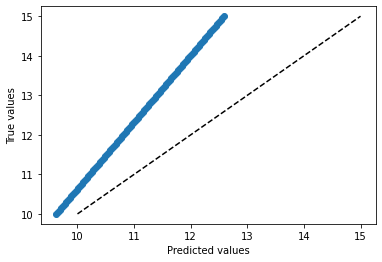

In [21]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01
delta = 0.5

def pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Objective function with L2 penalty."""
    w = params[1:]
    b = params[0]
    residual = y - np.dot(X, w) - b
    return np.mean(smooth_pinball(residual, tau=tau, delta=delta)) + lbda * np.sum(w ** 2)

def smooth_pinball_lbfgs_l2(X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Estimate w and b using L-BFGS.
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        The array of features.
    y : ndarray, shape (n_samples,)
        The target.
    lbda : float
        The regularization parameter lbda
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    w_hat : ndarray, shape (n_features,)
        The estimated w.
    b_hat : float
        The estimated b.
    """
    # TODO
    b_init=0
    w_init = np.zeros(X.shape[1])
    #rng = np.random.RandomState(42)  # initialize a random number generator with a fixed seed
    #b_init = rng.normal()  # sample a random value for b from a normal distribution
    #w_init = rng.normal(size=X.shape[1])  # sample random values for w from a normal distribution

    params_init = np.concatenate([[b_init], w_init])
    params_opt, _, _ = fmin_l_bfgs_b(pobj_l2,  x0=params_init, args=(X, y, lbda, tau, delta), approx_grad = True)

    b_hat = params_opt[0]
    w_hat = params_opt[1:]
    # END TODO
    return w_hat, b_hat



w_hat, b_hat = smooth_pinball_lbfgs_l2(X, y, lbda=0.01, tau=0.3, delta=0.5)
y_pred = np.dot(X, w_hat) + b_hat

# TODO  (visualization of the fit)

# Scatter plot of the points (y_pred, y_true)
plt.scatter(y_pred, y_true)

# Add a reference line y = x
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')

# Set the x and y labels
plt.xlabel('Predicted values')
plt.ylabel('True values')

# Show the plot
plt.show()

# END TODO

## Part 2: Smooth quantile regression with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [22]:
def pobj_l1(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    w = params[1:]
    b = params[0]
    return np.mean(smooth_pinball(y - np.dot(X, w) - b, tau=tau, delta=delta)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [23]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

#### QUESTION 7a:
- Implement the proximal gradient descent (PGD) method.

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Smooth pinball term without regularization term).

In [24]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step * grad(x, *grad_args), step, *prox_args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

#### QUESTION 7b:</b>
- Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
- Using the monitor class and the plot_epochs function, display the convergence.

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [25]:
def prox_R2(params, reg=1.):
    # TODO
    w = params[1:]
    b = params[0]
    w_prox = np.divide(w, 1 + 2 * reg, out=np.zeros_like(w), where=w != 0)
    params_prox = np.concatenate([[b], w_prox])

    # END TODO
    return params_prox


def prox_R1(params, reg=1.):
    # TODO
    w = params[1:]
    b = params[0]
    w_prox = np.sign(w) * np.maximum(np.abs(w) - reg, 0)
    params_prox = np.concatenate([[b], w_prox])

    # END TODO
    return params_prox


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

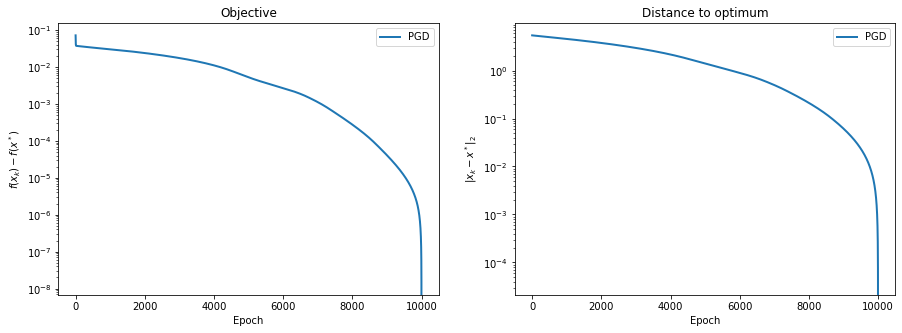

In [27]:
# Generate bigger data
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 10_000
lbda = 1
delta = 0.5
tau = 0.5

# TODO (implement function grad_smooth_pinball_loss and define step)
def grad_smooth_pinball_loss(params, X, y, tau, delta):
    """Compute the gradient of the smooth pinball loss.
    
    Parameters
    ----------
    params : ndarray, shape (n_features + 1,)
        The array containing the values of w and b.
    X : ndarray, shape (n_samples, n_features)
        The array of features.
    y : ndarray, shape (n_samples,)
        The target.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    grad : ndarray, shape (n_features + 1,)
        The gradient of the smooth pinball loss.
    """
    w = params[1:]
    b = params[0]
    residual = y - np.dot(X, w) - b
    grad_w = -np.mean(grad_smooth_pinball(residual, tau=tau, delta=delta)[:, None] * X, axis=0)
    grad_b = -np.mean(grad_smooth_pinball(residual, tau=tau, delta=delta))
    grad = np.concatenate([[grad_b], grad_w])
    return grad


def lip_constant(X):
    svdx = np.linalg.svd(X, full_matrices=True, compute_uv=True)[1]
    L = (2/n_samples)*svdx.max()**2
    return L

def lip_constant_2(X):
    L = (2/n_samples)*(np.sum(X**2))
    return L


lips_cont = lip_constant(X)
step = 1./lips_cont
step = 0.1
# END TODO

# Get a good x_min by letting the algorithm converge with many iterations
x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

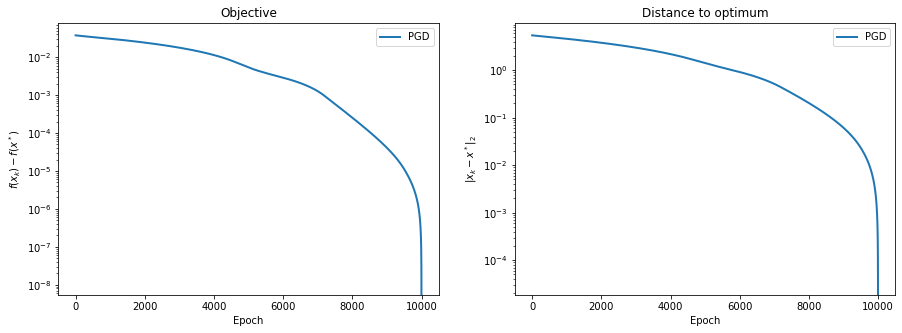

In [413]:
# Run PGD for L1

x_min_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

QUESTION 8:
- Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.

In [414]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        x_new = prox(y - step * grad(y, *grad_args), step, *prox_args)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y_new = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        y = y_new
        t = t_new
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

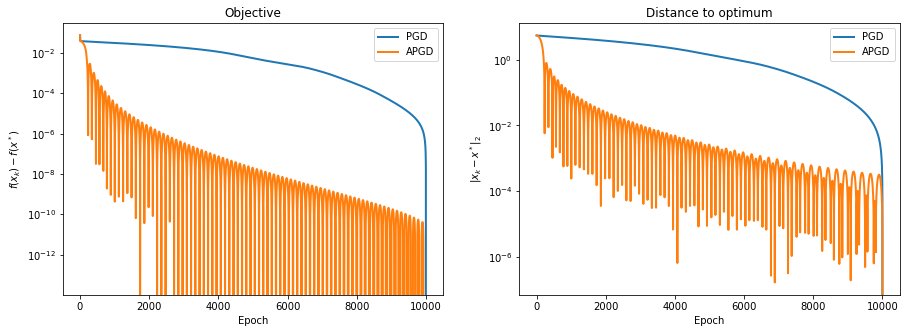

In [415]:
# TODO
x_min_agpd_l2, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))

# Run PGD
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min_agpd_l2, args=(X, y, lbda, tau, delta))
monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

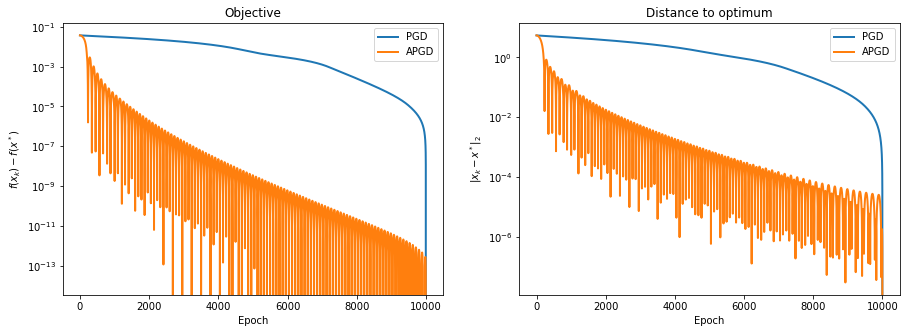

In [416]:
# TODO
x_min_agpd_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))

# Run PGD
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min_agpd_l1, args=(X, y, lbda, tau, delta))
monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

#### QUESTION 9
- Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [417]:
def grad_cd(params, j, X=X, y=y, tau=tau, delta=delta):
    n_samples = np.shape(X)[0]
    w = params[1:]
    b = params[0]
    if j == 0: 
        return  - np.mean(grad_smooth_pinball(y - X.dot(w) - b, tau=tau, delta=delta))
    return - (1. / n_samples) * X[:, j - 1].dot(grad_smooth_pinball(y - X.dot(w) - b, tau=tau, delta=delta))

In [418]:
# TODO
def pcd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):

    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x[0] =  x[0] - step[0] * grad(x, 0, *grad_args)

        for j in range(1, len(x)):
            x[j] = prox(np.array([0, x[j] - step[j] * grad(x, j, *grad_args)]), step[j], *prox_args)[1]
            
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list
# END TODO

In [419]:
def step_const_pcd(X):
    n_samples = np.shape(X)[0]
    return 0.5/( np.append(1, np.diag(np.dot(X.T, X))/n_samples))

stepsv = step_const_pcd(X)

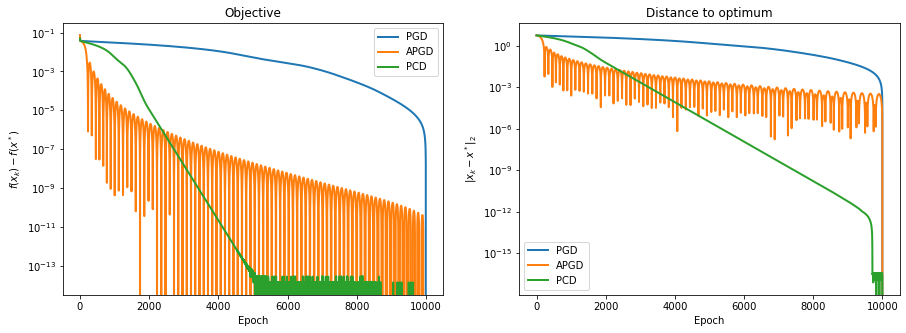

In [308]:
x_min_pcd_l2, _ = pcd(x_init, grad_cd, prox_l2, stepsv, 10000, 1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pcd_l2 = monitor(pcd, pobj_l2, x_min=x_min_pcd_l2, args=(X, y, lbda, tau, delta))
monitor_pcd_l2.run(x_init, grad_cd, prox_l2, stepsv, n_iter, grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2, monitor_apgd_l2, monitor_pcd_l2]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

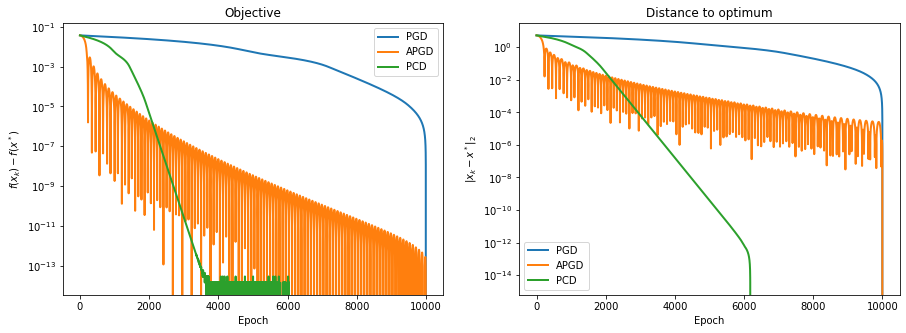

In [420]:
x_min_pcd_l1, _ = pcd(x_init, grad_cd, prox_l1, stepsv, 10000, 1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_pcd_l1, args=(X, y, lbda, tau, delta))
monitor_pcd_l1.run(x_init, grad_cd, prox_l1, stepsv, n_iter, grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
solvers = ["PGD", "APGD", "PCD"]
plot_epochs(monitors, solvers)

#### QUESTION 10
- Compare the performance of the different solvers for different (simulated) problem sizes. You will test on a dataset with n_samples >> n_features, n_samples << n_features, and for high and low values of $\lambda$.
- What solver would you recommend for each of the 4 scenarios?

**Remark:** What is expected from you here is to provide clear and synthetic plots that show the performance of the different solvers for the different simulated datasets.

n_samples: 50
n_features: 50
PGD: elapsed time = 1.467186
APGD: elapsed time = 1.571092
PCD: elapsed time = 29.437343


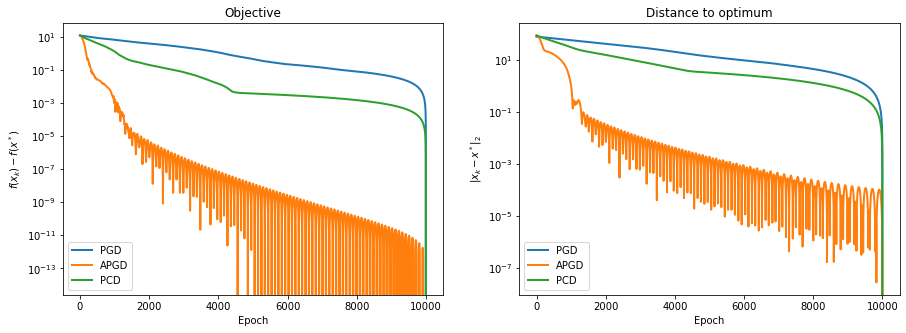

n_samples: 50
n_features: 1000
PGD: elapsed time = 2.652428
APGD: elapsed time = 2.614580
PCD: elapsed time = 620.311614


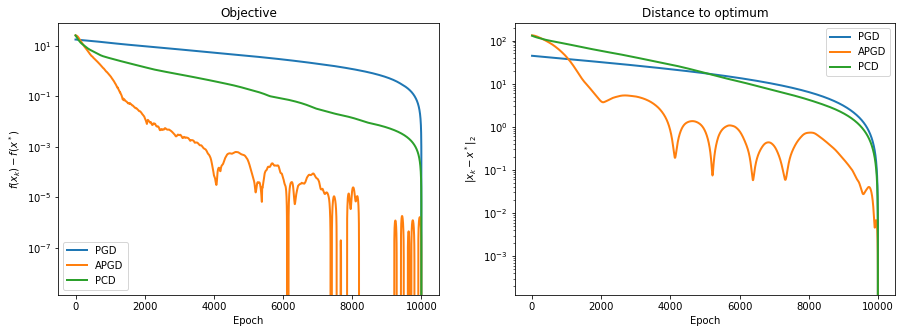

n_samples: 1000
n_features: 50
PGD: elapsed time = 3.183490
APGD: elapsed time = 3.067145
PCD: elapsed time = 49.797918


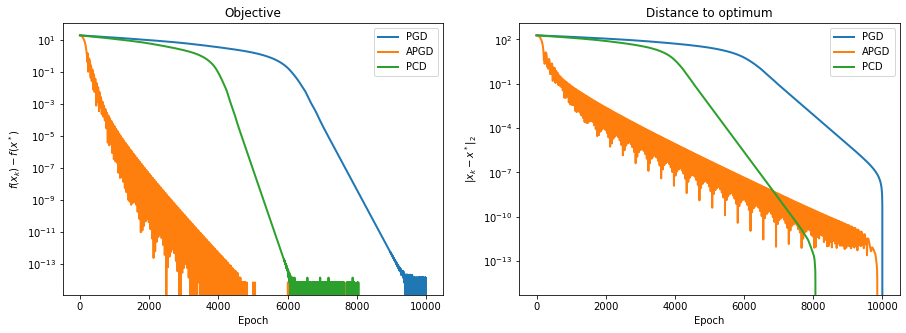

In [407]:
for _n_samples in  [50,1000]:
    for _n_features in [50, 1000]:
        if _n_samples == _n_features and _n_samples==1000:
            break
        
        print("=================================")
        print("n_samples:",_n_samples)
        print("n_features:",_n_features)
        X, y = make_regression(n_samples=_n_samples, n_features=_n_features, random_state = 24,
                               noise=4.0, bias=10.0)
        n_samples, n_features = X.shape

        # Set initial values of parameters to optimize
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)
        n_iter = 10000 #2000
        lbda = 0.1
        #lbda = 1
        delta = 0.5
        tau = 0.5
        L= lip_constant(X)
        step = 1/L
        step_vector = 0.5/( np.append(1, np.diag(np.dot(X.T, X))/n_samples) )
        
        tic = time.time()
        x_min_pgd_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
        toc = time.time()
        print(f"PGD: elapsed time = {toc - tic:.6f}")
    
        tic = time.time()
        x_min_agpd_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                        grad_args=(X, y, tau, delta), prox_args=(lbda,))
        toc = time.time()
        print(f"APGD: elapsed time = {toc - tic:.6f}")    

        tic = time.time()
        x_min_pcd_l1, _ = pcd(x_init, grad_cd, prox_l1, step_vector, 10000, 1, (X, y, tau,delta), (lbda,))
        toc = time.time()
        print(f"PCD: elapsed time = {toc - tic:.6f}")

        monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_pgd_l1, args=(X, y, lbda, tau,delta))
        monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter, grad_args=(X, y, tau,delta), prox_args=(lbda,))

        monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_agpd_l1, args=(X, y, lbda, tau,delta))
        monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter, grad_args=(X, y, tau,delta), prox_args=(lbda,))

        monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_pcd_l1, args=(X, y, lbda, tau,delta))
        monitor_pcd_l1.run(x_init, grad_cd, prox_l1, step_vector, n_iter, grad_args=(X, y, tau,delta), prox_args=(lbda,))

        monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
        solvers = ["PGD", "APGD", "PCD"]
        plot_epochs(monitors, solvers)
        plt.show()

Problem size: n_samples >> n_features
lambda = 0.01
PGD: elapsed time = 2.729951
APGD: elapsed time = 2.582182
PCD: elapsed time = 71.092734


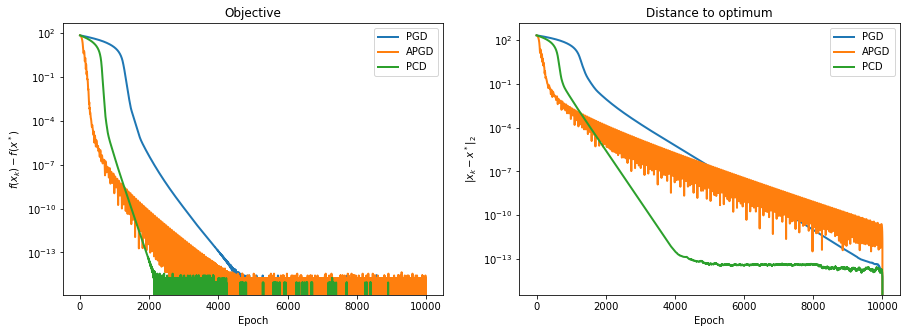

lambda = 0.1
PGD: elapsed time = 2.358570
APGD: elapsed time = 2.414684
PCD: elapsed time = 68.433708


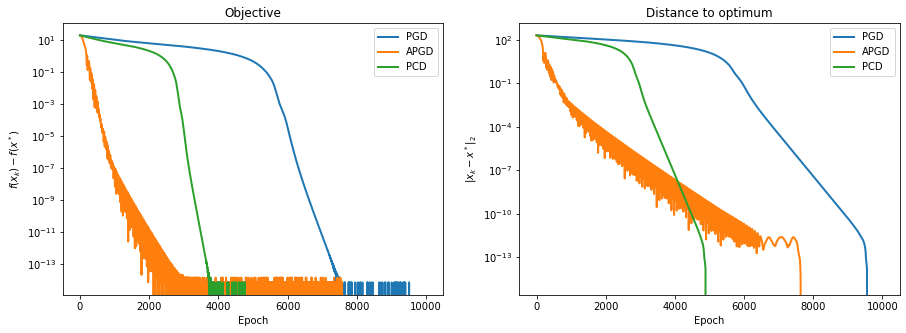

lambda = 0.99
PGD: elapsed time = 2.306098
APGD: elapsed time = 2.377469
PCD: elapsed time = 71.708064


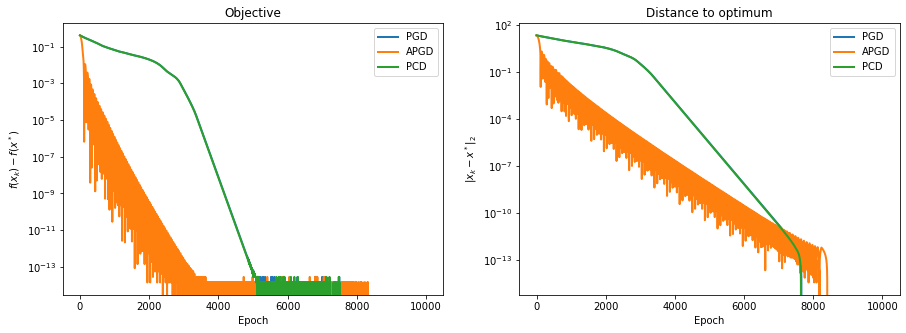

In [406]:
# Compare the solvers
lambdas = [0.01,0.1,0.99]
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
for lbda in lambdas:
    print(f"lambda = {lbda}")
    x_init = np.zeros(X.shape[1] + 1)
    L= lip_constant(X)
    step = 1/L
    step_vector = 0.5/( np.append(1, np.diag(np.dot(X.T, X))/n_samples) )
    tic = time.time()
    x_min_pgd_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                          grad_args=(X, y, tau, delta), prox_args=(lbda,))
    toc = time.time()
    print(f"PGD: elapsed time = {toc - tic:.6f}")#s, MSE = {mean_squared_error(beta, beta_pgd):.6f}")
    tic = time.time()
    x_min_agpd_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                            grad_args=(X, y, tau, delta), prox_args=(lbda,))
    toc = time.time()
    print(f"APGD: elapsed time = {toc - tic:.6f}")#s, MSE = {mean_squared_error(beta, beta_apgd):.6f}")
    tic = time.time()
    x_min_pcd_l1, _ = pcd(x_init, grad_cd, prox_l1, step_vector, 10000, 1, (X, y, tau,delta), (lbda,))
    toc = time.time()
    print(f"PCD: elapsed time = {toc - tic:.6f}")#s, MSE = {mean_squared_error(beta, beta_pcd):.6f}")
    
    monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_pgd_l1, args=(X, y, lbda, tau,delta))
    monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter, grad_args=(X, y, tau,delta), prox_args=(lbda,))

    monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_agpd_l1, args=(X, y, lbda, tau,delta))
    monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter, grad_args=(X, y, tau,delta), prox_args=(lbda,))

    monitor_pcd_l1 = monitor(pcd, pobj_l1, x_min=x_min_pcd_l1, args=(X, y, lbda, tau,delta))
    monitor_pcd_l1.run(x_init, grad_cd, prox_l1, step_vector, n_iter, grad_args=(X, y, tau,delta), prox_args=(lbda,))

    monitors = [monitor_pgd_l1, monitor_apgd_l1, monitor_pcd_l1]
    solvers = ["PGD", "APGD", "PCD"]
    plot_epochs(monitors, solvers)
    plt.show()

YOUR ANSWER HERE

n_samples >> n_features: In this scenario, we have a large number of samples and a small number of features. We may want to consider using PGD or APGD, as they are generally faster and require less memory than PCD.

n_samples << n_features: In this scenario, we have a small number of samples and a large number of features. we may want to consider using PCD, as it is specifically designed to handle problems with a large number of parameters.

High values of lambda: If the value of the regularization parameter lambda is high, we may want to consider using a solver that is specifically designed to exploit sparsity, such as PCD.

Low values of lambda: If the value of the regularization parameter lambda is low, we may want to consider using PGD or APGD, as they generally have faster convergence rates than PCD.

# Part 3: Application

You will now apply your solver to some census dataset where we aim to predict the wage of a person give some demographic and work related variables.

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration.

Let's first inspect the dataset:

In [384]:
from sklearn.datasets import fetch_openml
wages = fetch_openml(name="cps_85_wages", as_frame=True)
X_df, y_df = wages["data"], wages["target"]
X_df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


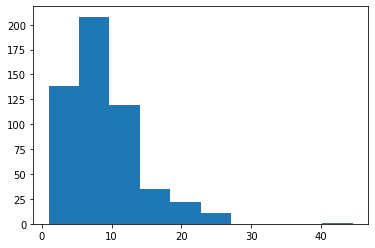

In [385]:
plt.hist(y_df);

In [386]:
X_df.dtypes

EDUCATION      float64
SOUTH         category
SEX           category
EXPERIENCE     float64
UNION         category
AGE            float64
RACE          category
OCCUPATION    category
SECTOR        category
MARR          category
dtype: object

Now let's extract `X` taking only the numerical columns (y is already defined above) and do some basic plot:

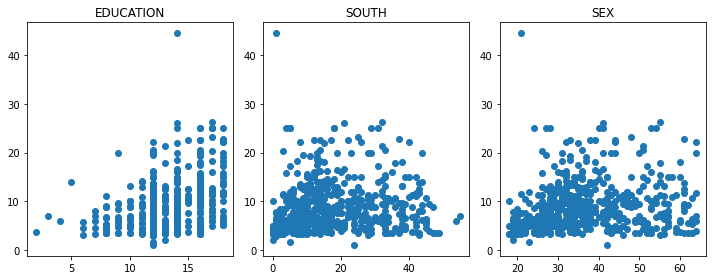

In [387]:
X_df_num = X_df.select_dtypes(include=(float, int))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
for x, col_name, ax in zip(X_df_num.values.T, X_df.columns, axes.ravel()):
    ax.plot(x, y_df, 'o')
    ax.set_title(col_name)
fig.tight_layout()

In [388]:
X = X_df_num.values
y = y_df.values
y.shape, X.shape

((534,), (534, 3))

We have now X and y!

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

#### QUESTION 11
- Implement the `fit` method from the estimator in the next cell and fit the model with the different solvers you implemented above.

In [394]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import scale


class SmoothQuantileRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a smoothed quantile loss.
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    tau : float in (0, 1)
        The quantile to predict.
    delta : float
        The smoothing parameter.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', tau=0.5, delta=0.5,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.tau = tau
        self.delta = delta
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        if self.solver == 'pcd':
            self.step = step_const_pcd(X)
        else:
            self.step = 1./lip_constant(X)
        x = np.zeros(n_features+1)
        
        #pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
        #       grad_args=(X, y, tau, delta), prox_args=(lbda,))
        
        if self.solver=='pgd':
            if self.penalty=='l2':
                x,_ = pgd(x, grad_smooth_pinball_loss, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X,y,self.tau,self.delta), prox_args=(self.lbda,))
            else:
                x,_ = pgd(x, grad_smooth_pinball_loss, prox_l1, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X,y,self.tau,self.delta), prox_args=(self.lbda,))
        if self.solver=='apgd':
            if self.penalty=='l2':
                x,_ = apgd(x, grad_smooth_pinball_loss, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
                           grad_args=(X,y,self.tau,self.delta), prox_args=(self.lbda,))
            else:
                x,_ = apgd(x, grad_smooth_pinball_loss, prox_l1, self.step, n_iter=self.max_iter, store_every=1,
                           grad_args=(X,y,self.tau,self.delta), prox_args=(self.lbda,))
        if self.solver=='pcd':
            if self.penalty=='l2':
                x,_ = pcd(x, grad_cd, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X,y,self.tau,self.delta), prox_args=(self.lbda,))
            else:
                x,_ = pcd(x, grad_cd, prox_l1, self.step, n_iter=self.max_iter, store_every=1,
                          grad_args=(X,y,self.tau,self.delta), prox_args=(self.lbda,))
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using the pinball loss.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative pinball loss.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(pinball(y - self.predict(X), tau=self.tau))

lbda = 1e-4
max_iter = 1000

X_scaled = scale(X)  # standardize the features

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L2: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l1', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L1: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   Pinball : 34.65790
Solver with L2: apgd   	-   Pinball : 29.27789
Solver with L2: pcd   	-   Pinball : 34.17135
Solver with L1: pgd   	-   Pinball : 34.71677
Solver with L1: apgd   	-   Pinball : 16.51428
Solver with L1: pcd   	-   Pinball : 34.21468


To illustrate the predicitons here is a simple plot where you should see the interval of the predictions with 3 different quantiles. Feel free to comment on what you see and go beyond this plot if you feel inspired !

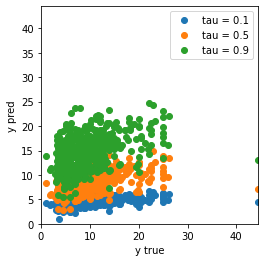

In [395]:
fig, ax = plt.subplots()
for tau in [0.1, 0.5, 0.9]:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', solver="apgd", tau=tau)
    y_pred = clf.fit(X_scaled, y).predict(X_scaled)
    ax.plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
    ax.axis("square")

ax.set(xlabel="y true", ylabel="y pred", xlim=(0, np.max(y)), ylim=(0, np.max(y)))
plt.legend();